In [1]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, mean_squared_error
from sklearn.metrics.cluster import contingency_matrix
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.stats import ttest_ind
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl

import scanpy as sc

import networkx as nx

from tqdm import tqdm

from functools import partial 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim.lr_scheduler import StepLR
import torch.autograd as autograd

import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings

Parameter settings

In [2]:
latent_dim=32
sub_clusters=2
gp_weight=1
K=5
G_epoch=3
D_epoch=1
num_epochs=600

Data preprocessing

/root/miniconda3/envs/pytorch/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/root/miniconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


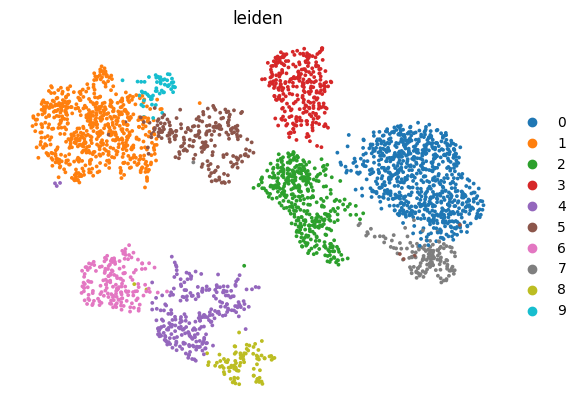

In [3]:
df_drop_data = pd.read_csv('./Zeisel_DR30%.csv',index_col=0).T
drop_data=df_drop_data.values
ncell,ngene = drop_data.shape

data_cpoy = df_drop_data.copy()
adata = sc.AnnData(X=data_cpoy.values, obs=pd.DataFrame(index=data_cpoy.index), var=pd.DataFrame(index=data_cpoy.columns), dtype='float32')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
norm_data = adata.X
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata,n_neighbors=5, n_pcs=40, use_rep='X_pca')
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', frameon=False, size=30, legend_fontweight='normal', show=True, save=False)

pca_matrix = adata.obsm['X_umap']
leiden_labels = adata.obs['leiden'].cat.codes.to_numpy()
label_leiden_tensor=torch.tensor(leiden_labels, dtype=torch.int32)
N_leiden=len(np.unique(leiden_labels))

Pre-clustering

In [4]:
def cluster_data(pcs, method, n_cluster):
    """ Cluster data based on the specified method. """
    if method == 'kmeans':
        model = KMeans(n_clusters=n_cluster, random_state=1)
    elif method == 'spectral':
        model = SpectralClustering(n_clusters=n_cluster, random_state=1,
                                   affinity='nearest_neighbors', assign_labels='discretize')
    else:
        raise ValueError("Unsupported clustering method. Choose 'kmeans' or 'spectral'.")
    return model.fit_predict(pcs)

def cluster(X, n_cluster, cluster_method, leiden_label=None, N_leiden=None):
    """ Main clustering function with precomputed Leiden labels. """
    
    print(f'{cluster_method} Begin!!!')
    
    data = X.copy()
    
    if cluster_method == 'leiden' and leiden_label is not None:
        labels = leiden_label
        n_cluster = N_leiden
    else:
        labels = cluster_data(data, cluster_method, n_cluster)

    # Counting cells in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f'Cluster {label}: {count} cells')

    return labels
    
kmeans_labels = cluster(pca_matrix, N_leiden,'kmeans')
kmeans_labels_tensor=torch.tensor(kmeans_labels, dtype=torch.int32)
spectral_labels = cluster(pca_matrix, N_leiden,'spectral')
spectral_labels_tensor=torch.tensor(spectral_labels, dtype=torch.int32)

kmeans Begin!!!
Cluster 0: 309 cells
Cluster 1: 181 cells
Cluster 2: 208 cells
Cluster 3: 273 cells
Cluster 4: 294 cells
Cluster 5: 402 cells
Cluster 6: 272 cells
Cluster 7: 490 cells
Cluster 8: 263 cells
Cluster 9: 313 cells
spectral Begin!!!


/root/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/root/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Cluster 0: 300 cells
Cluster 1: 501 cells
Cluster 2: 444 cells
Cluster 3: 284 cells
Cluster 4: 175 cells
Cluster 5: 221 cells
Cluster 6: 158 cells
Cluster 7: 407 cells
Cluster 8: 229 cells
Cluster 9: 286 cells


Identify dropout events

In [5]:
def find_cluster_cell_idx(l, label):
    
    return label == l

label_set = np.unique(leiden_labels)
cluster_cell_idxs = list(map(partial(find_cluster_cell_idx, label=leiden_labels), label_set))

def identify_dropout(cluster_cell_idxs, X):
    for idx in cluster_cell_idxs:
        dropout=(X[:,idx]==0).sum(axis=1)/(X[:,idx].shape[1])
        dropout_thr=0.9
        dropout_upper_thr,dropout_lower_thr = np.nanquantile(dropout,q=dropout_thr),np.nanquantile(dropout,q=0)
        gene_index1 = (dropout<=dropout_upper_thr)&(dropout>=dropout_lower_thr)
        #print(gene_index1)
        cv = X[:,idx].std(axis=1)/X[:, idx].mean(axis=1)
        cv_thr=0.9
        cv_upper_thr,cv_lower_thr = np.nanquantile(cv,q=cv_thr),np.nanquantile(cv,q=0)
        #print(cv_upper_thr,cv_lower_thr)
        gene_index2 = (cv<=cv_upper_thr)&(cv>=cv_lower_thr)
        #print(gene_index2)
        #include_faslezero_gene= list(np.intersect1d(gene_index1,gene_index2))
        include_faslezero_gene = np.logical_and(gene_index1, gene_index2)
        #print(list(include_faslezero_gene).count(True))
        tmp = X[:, idx]
        tmp[include_faslezero_gene] = tmp[include_faslezero_gene]+(tmp[include_faslezero_gene]==0)*-1
        X[:, idx] = tmp
    return X

data_identi = identify_dropout(cluster_cell_idxs, X=norm_data.T).T
raw_data = torch.tensor(drop_data, dtype=torch.float32)
mask_tensor = torch.ones_like(raw_data, dtype=torch.bool)
mask_tensor[data_identi == -1] = False

false_count = torch.sum(~mask_tensor).item()
total_elements = mask_tensor.numel()
false_ratio = false_count / total_elements
false_ratio

/tmp/ipykernel_1172/2787960140.py:15: RuntimeWarning: invalid value encountered in divide
  cv = X[:,idx].std(axis=1)/X[:, idx].mean(axis=1)


0.46453826955074873

Constructing CA

In [6]:
def compute_labels_relation(pcs, labels, n_clusters, sub_clusters):

    # Initialize dictionaries and lists for storing results
    sub_cluster_centers_dict = {}
    sub_label_indices_dict = {}
    main_cluster_centers = {}

    # Compute main cluster centers for each unique label
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        main_cluster_centers[label] = pcs[indices].mean(axis=0)

    # Compute sub-clusters within each main cluster
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        if len(indices) > 1:
            # Hierarchical clustering to find sub-clusters
            Z_sub = linkage(pcs[indices], method='ward')
            sub_labels = fcluster(Z_sub, sub_clusters, criterion='maxclust')
            sub_cluster_centers = [pcs[indices][sub_labels == j].mean(axis=0) for j in range(1, sub_labels.max() + 1)]
            for idx, idx_global in enumerate(indices):
                sub_label_indices_dict[idx_global] = sub_labels[idx] - 1
            sub_cluster_centers_dict[label] = sub_cluster_centers
        else:
            # Handle cases with a single index
            sub_cluster_centers_dict[label] = [pcs[indices].mean(axis=0)]
            sub_label_indices_dict[indices[0]] = 0

    # Compute pairwise distances using PCA-based distance matrix
    pca_distance_matrix = squareform(pdist(pcs, metric='euclidean'))
    #pca_distance_matrix = np.zeros(pca_distance_matrix.shape)
    weight_matrix = np.zeros((len(labels), len(labels)))

    # Fill weight matrix based on distances
    for i in range(len(labels)):
        for j in range(i, len(labels)):
            sub_cluster_i = sub_label_indices_dict.get(i, -1)
            sub_cluster_j = sub_label_indices_dict.get(j, -1)
            if labels[i] == labels[j] and sub_cluster_i != -1 and sub_cluster_j != -1:
                if sub_cluster_i == sub_cluster_j:
                    distance = pca_distance_matrix[i, j]
                else:
                    distance = np.linalg.norm(sub_cluster_centers_dict[labels[i]][sub_cluster_i] -
                                              sub_cluster_centers_dict[labels[j]][sub_cluster_j])
            else:
                main_center_i = main_cluster_centers[labels[i]]
                main_center_j = main_cluster_centers[labels[j]]
                distance = np.linalg.norm(main_center_i - main_center_j)

            weight_matrix[i, j] = weight_matrix[j, i] = 1 / (1 + distance)

    return weight_matrix


Relation_matrix = compute_labels_relation(pca_matrix,leiden_labels,N_leiden,sub_clusters)
Relation_matrix

array([[1.        , 0.60307748, 0.52405539, ..., 0.07287224, 0.07171499,
        0.07287224],
       [0.60307748, 1.        , 0.74118567, ..., 0.07287224, 0.07171499,
        0.07287224],
       [0.52405539, 0.74118567, 1.        , ..., 0.07287224, 0.07171499,
        0.07287224],
       ...,
       [0.07287224, 0.07287224, 0.07287224, ..., 1.        , 0.20929147,
        0.29734528],
       [0.07171499, 0.07171499, 0.07171499, ..., 0.20929147, 1.        ,
        0.20929147],
       [0.07287224, 0.07287224, 0.07287224, ..., 0.29734528, 0.20929147,
        1.        ]])

Gragh-cGAN

In [7]:
label_dim=N_leiden

class ConditionalBatchNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConditionalBatchNorm, self).__init__()
        self.bn = nn.BatchNorm1d(num_features, affine=False)  # 关闭仿射参数
        self.gamma = nn.Embedding(num_classes, num_features)
        self.beta = nn.Embedding(num_classes, num_features)

    def forward(self, x, y):
        out = self.bn(x)
        gamma = self.gamma(y)
        beta = self.beta(y)
        return gamma * out + beta  # 条件缩放和偏移


class GraphConvolution(nn.Module):
    def __init__(self, init_dim, mid_dim_1, mid_dim_2, mid_dim_3, mid_dim_4, output_dim,
                 num_classes, dropout_rate=0.5, use_bias=True, use_labels=False):
        super(GraphConvolution, self).__init__()
        
        self.use_bias = use_bias
        self.use_labels = use_labels  # 控制是否使用标签信息

        # 定义权重矩阵列表
        self.weights = nn.ParameterList([
            nn.Parameter(torch.Tensor(init_dim, mid_dim_1)),
            nn.Parameter(torch.Tensor(mid_dim_1, mid_dim_2)),
            nn.Parameter(torch.Tensor(mid_dim_2, mid_dim_3)),
            nn.Parameter(torch.Tensor(mid_dim_3, mid_dim_4)),
            nn.Parameter(torch.Tensor(mid_dim_4, output_dim))
        ])

        # 定义残差映射模块，仅在维度不匹配时进行线性映射
        self.residual_mappings = nn.ModuleList([
            nn.Linear(init_dim, mid_dim_1) if init_dim != mid_dim_1 else None,
            nn.Linear(mid_dim_1, mid_dim_2) if mid_dim_1 != mid_dim_2 else None,
            nn.Linear(mid_dim_2, mid_dim_3) if mid_dim_2 != mid_dim_3 else None,
            nn.Linear(mid_dim_3, mid_dim_4) if mid_dim_3 != mid_dim_4 else None
        ])

        # 定义批归一化模块：支持条件批归一化或普通批归一化
        self.bns = nn.ModuleList([
            ConditionalBatchNorm(mid_dim_1, num_classes) if use_labels else nn.BatchNorm1d(mid_dim_1),
            ConditionalBatchNorm(mid_dim_2, num_classes) if use_labels else nn.BatchNorm1d(mid_dim_2),
            ConditionalBatchNorm(mid_dim_3, num_classes) if use_labels else nn.BatchNorm1d(mid_dim_3),
            ConditionalBatchNorm(mid_dim_4, num_classes) if use_labels else nn.BatchNorm1d(mid_dim_4),
            ConditionalBatchNorm(output_dim, num_classes) if use_labels else nn.BatchNorm1d(output_dim)
        ])

        # 定义偏置项（可选）
        self.biases = nn.ParameterList([
            nn.Parameter(torch.Tensor(mid_dim_1)) if use_bias else None,
            nn.Parameter(torch.Tensor(mid_dim_2)) if use_bias else None,
            nn.Parameter(torch.Tensor(mid_dim_3)) if use_bias else None,
            nn.Parameter(torch.Tensor(mid_dim_4)) if use_bias else None,
            nn.Parameter(torch.Tensor(output_dim)) if use_bias else None
        ])

        # 参数初始化
        self.reset_parameters()

        # 定义激活函数和 Dropout 层
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def reset_parameters(self):
        """
        初始化权重和偏置项。
        """
        for weight in self.weights:
            nn.init.kaiming_uniform_(weight, a=math.sqrt(5))
        for bias in self.biases:
            if bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(bias, -bound, bound)

    def forward(self, input_data, adj, y=None):
        
        x = input_data

        for i, weight in enumerate(self.weights[:-1]):
            x_res = x  # 保留输入用于残差连接

            # 执行图卷积操作
            x = torch.matmul(adj, x)
            x = torch.matmul(x, weight)

            # 如果需要，应用残差映射
            if self.residual_mappings[i] is not None:
                x_res = self.residual_mappings[i](x_res)

            # 残差连接
            x = x + x_res

            # 选择使用条件批归一化或普通批归一化
            if self.use_labels:
                x = self.bns[i](x, y)  # 使用条件批归一化
            else:
                x = self.bns[i](x)  # 使用普通批归一化

            # 激活函数和 Dropout
            x = self.activation(x)
            x = self.dropout(x)

        # 最后一层（不使用残差连接）
        x = torch.matmul(adj, x)
        x = torch.matmul(x, self.weights[-1])
        x = self.activation(x)

        return x

class Generator(nn.Module):
    def __init__(self, gene_dim, num_classes, latent_dim=latent_dim, label_embedding_dim=label_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, label_embedding_dim)
        combined_dim = latent_dim + label_embedding_dim
        self.graph_conv = GraphConvolution(combined_dim, 128, 256, 512, 1024, gene_dim, num_classes)
        self.relu = nn.ReLU()                        

    def forward(self, noise, labels, adj):
        labels_emb = self.label_emb(labels.long())
        x = torch.cat((noise, labels_emb), dim=1)
        x = self.graph_conv(x, adj, labels)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim, mid_dim_1, mid_dim_2, mid_dim_3, mid_dim_4, num_classes, label_embedding_dim=label_dim, use_bias=True):
        super(Discriminator, self).__init__()
        self.use_bias = use_bias

        # 类别嵌入
        self.label_emb = nn.Embedding(num_classes, label_embedding_dim)
        
        # 输入维度需要加上类别嵌入的维度
        combined_dim = input_dim + label_embedding_dim

        # 定义层
        self.layers = nn.ModuleList([
            nn.Linear(combined_dim, mid_dim_1, bias=use_bias),
            nn.LeakyReLU(0.02, inplace=True),  
            nn.Linear(mid_dim_1, mid_dim_2, bias=use_bias),
            nn.LeakyReLU(0.02, inplace=True),
            nn.Linear(mid_dim_2, mid_dim_3, bias=use_bias),
            nn.LeakyReLU(0.02, inplace=True),
            nn.Linear(mid_dim_3, mid_dim_4, bias=use_bias),
            nn.LeakyReLU(0.02, inplace=True),
            nn.Linear(mid_dim_4, 1, bias=use_bias)  
        ])

    def forward(self, x, labels):
        
        labels_emb = self.label_emb(labels.long())
        
        x = torch.cat((x, labels_emb), dim=1)

        for i in range(0, len(self.layers) - 1, 2):
            x = self.layers[i](x)
            x = self.layers[i + 1](x) 
            
        x = self.layers[-1](x)
        return x

def A_lap_norm(combined_matrix, top_k):
    num_cells = combined_matrix.shape[0]
    
    np.fill_diagonal(combined_matrix, 0)  # 清除自连接

    adj_matrix = np.zeros((num_cells, num_cells))
    
    for i in range(num_cells):
        # 获取排序后的索引，排除噪声细胞
        neighbors = np.argsort(-combined_matrix[i]) 
        top_k_neighbors = neighbors[:top_k] 

        # 设置邻接矩阵
        adj_matrix[i, top_k_neighbors] = 1

    # 对称化邻接矩阵
    adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
    
    
    # 拉普拉斯归一化
    degree_matrix = np.sum(adj_matrix, axis=1)
    degree_matrix_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))
    laplacian_matrix = degree_matrix_inv_sqrt @ adj_matrix @ degree_matrix_inv_sqrt
    
    
    L = torch.tensor(laplacian_matrix, dtype=torch.float)
    
    return L

CA_tensor=A_lap_norm(Relation_matrix,K)
CA_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Model training

In [8]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels, device, target_norm=1):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real_samples)
    
    # 插值计算
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)
    
    # 计算判别器对插值样本的输出
    d_interpolates = D(interpolates, labels)
    fake = torch.ones_like(d_interpolates, device=device)
    
    # 计算插值样本的梯度
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # 计算梯度惩罚
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - target_norm) ** 2).mean()

    return gradient_penalty

def train_DCImpute(generator, discriminator, gene_data, adj_matrix, num_epochs, labels=label_leiden_tensor, 
                  mask=mask_tensor, labels_sub1=kmeans_labels_tensor, labels_sub2=spectral_labels_tensor, 
                  latent_dim=latent_dim, gp_weight=gp_weight, G_epoch=G_epoch, D_epoch=D_epoch, device=torch.device("cuda")):
    
    generator.to(device)
    discriminator.to(device)
    real_genes = gene_data.to(device)
    labels = labels.to(device)
    labels_sub1 = labels_sub1.to(device)
    labels_sub2 = labels_sub2.to(device)
    adj_matrix = adj_matrix.to(device)
    mask = mask.to(device)

    consistency_loss_fn = nn.MSELoss()
    l1_loss_fn = nn.MSELoss()

    zero_tensor = torch.zeros_like(real_genes)
    l1_first = l1_loss_fn(real_genes, zero_tensor).item()

    lr_updated1 = True
  
    sigma1 = torch.tensor(1.0, requires_grad=True, device=device)
    sigma2 = torch.tensor(1.0, requires_grad=True, device=device)
    sigma3 = torch.tensor(1.0, requires_grad=True, device=device)
    
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999))
    # 新增：权重的优化器
    sigma_optimizer = optim.Adam([sigma1, sigma2, sigma3], lr=0.00001)

    g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=50, gamma=0.8)
    d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=50, gamma=0.8)
    
    losses = {"D_loss": [], "G_loss": [], "Consistency": [], "L1": [], "Total": []}

    for epoch in range(num_epochs):
        for _ in range(D_epoch):  # Critic iterations
            noise = torch.rand(real_genes.size(0), latent_dim, device=device)
            fake_genes = generator(noise, labels, adj_matrix)
            fake_genes = fake_genes * mask
            
            d_optimizer.zero_grad()
            real_validity = discriminator(real_genes, labels)
            fake_validity = discriminator(fake_genes.detach(), labels)
            
            gradient_penalty = compute_gradient_penalty(discriminator, real_genes, fake_genes, labels, device)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gp_weight * gradient_penalty
            d_loss.backward()
            d_optimizer.step()
            d_scheduler.step()

        for _ in range(G_epoch):  # Generator iterations
            g_optimizer.zero_grad()
            noise = torch.rand(real_genes.size(0), latent_dim, device=device)
            fake_genes = generator(noise, labels, adj_matrix)
            fake_genes = fake_genes * mask
            
            fake_data_sub1 = generator(noise, labels_sub1, adj_matrix) * mask
            fake_data_sub2 = generator(noise, labels_sub2, adj_matrix) * mask
            
            consistency_loss = consistency_loss_fn(fake_data_sub1, fake_genes) + consistency_loss_fn(fake_data_sub2, fake_genes)
            fake_loss = -torch.mean(discriminator(fake_genes, labels))
            L1_loss = l1_loss_fn(real_genes, fake_genes)
            
            # 新增：损失函数加权
            g_loss = 0.5 / sigma1**2 * fake_loss + 0.5 / sigma2**2 * L1_loss + 0.5 / sigma3**2 * consistency_loss + torch.log(sigma1 * sigma2 * sigma3)
            g_loss.backward()
            g_optimizer.step()
            sigma_optimizer.step()
            if not lr_updated1:
                g_scheduler.step()

        losses["D_loss"].append(d_loss.item())
        losses["G_loss"].append(fake_loss.item())
        losses["Consistency"].append(consistency_loss.item())
        losses["L1"].append(L1_loss.item())
        losses["Total"].append(g_loss.item())

        if epoch % 10 == 0:
            l1_ing = L1_loss.item()
            if lr_updated1 and l1_ing > l1_first * 0.5:
                for param_group in g_optimizer.param_groups:
                    print(f"Learning rate updated to {param_group['lr']} at epoch {epoch}")
            else:
                lr_updated1 = False
            
            print(f"Epoch {epoch}: D_loss = {d_loss.item()}, G_loss = {fake_loss.item()}, Consistency = {consistency_loss.item()}, L1 = {L1_loss.item()}")
        
    return losses, generator

G = Generator(ngene,N_leiden)
D = Discriminator(ngene,1024,256,64,16,N_leiden)

losses, trained_generator = train_DCImpute(G, D,raw_data,CA_tensor,num_epochs)

/root/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Learning rate updated to 0.0002 at epoch 0
Epoch 0: D_loss = 1.074303150177002, G_loss = 0.018405292183160782, Consistency = 0.04076974093914032, L1 = 531.9827270507812
Learning rate updated to 0.0002 at epoch 10
Epoch 10: D_loss = 0.5663926005363464, G_loss = -0.030629264190793037, Consistency = 0.7269232273101807, L1 = 515.1166381835938
Learning rate updated to 0.0002 at epoch 20
Epoch 20: D_loss = -0.22035223245620728, G_loss = 0.09959133714437485, Consistency = 0.9602131843566895, L1 = 506.6123352050781
Learning rate updated to 0.0002 at epoch 30
Epoch 30: D_loss = -1.4352400302886963, G_loss = 0.5116809606552124, Consistency = 1.1869844198226929, L1 = 501.1182556152344
Learning rate updated to 0.0002 at epoch 40
Epoch 40: D_loss = -2.9909355640411377, G_loss = 1.0406125783920288, Consistency = 1.3782389163970947, L1 = 496.78436279296875
Learning rate updated to 0.0002 at epoch 50
Epoch 50: D_loss = -4.906074047088623, G_loss = 1.6518871784210205, Consistency = 1.5616466999053955, 

Imputation

In [9]:
def imp_example(label_tensor, adj_tensor, G, original_data, mask_tensor, latent_dim=latent_dim):
    # Ensure all input tensors are on the same device as the generator
    device = next(G.parameters()).device
    label_tensor = label_tensor.to(device)
    adj_tensor = adj_tensor.to(device)
    mask_tensor = mask_tensor.to(device)  # Ensure mask_tensor is also on the same device
    
    # Generate noise on the same device
    noise = torch.randn(original_data.shape[0], latent_dim, device=device)
    
    G.eval()  # Set the generator to evaluation mode
    
    with torch.no_grad():
        # Generate data and move it to CPU for further processing with numpy
        generated_data = G(noise, label_tensor, adj_tensor).cpu().numpy()
    
    # Impute the original data only where mask_tensor is False (i.e., original_data was zero)
    imp = np.where(mask_tensor.cpu().numpy() == False, generated_data, original_data)
    imp = np.round(imp)  # Optionally round the imputed values
    
    return imp,generated_data

imputed_data, generated_data = imp_example(label_leiden_tensor, CA_tensor, trained_generator, drop_data, mask_tensor)

df_Imp = pd.DataFrame(imputed_data, index=df_drop_data.index, columns=df_drop_data.columns)
df_Imp.T.to_csv('./GDCC_imputed.csv')

UMAP visualization

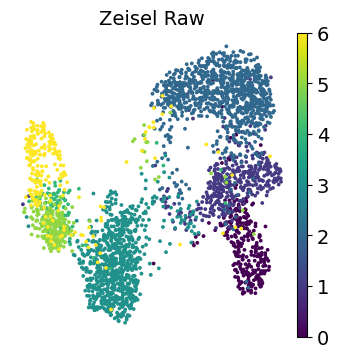

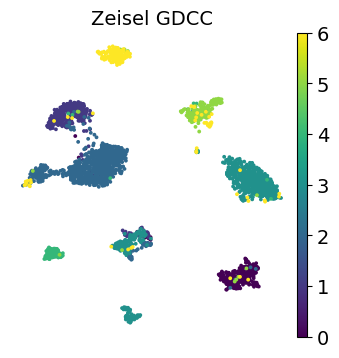

In [11]:
def Norm_View(data, label, x):
    
    sc.settings.set_figure_params(dpi=50, dpi_save=600, figsize=(4, 4))
    data_cells_genes = data.copy()
    obs = pd.DataFrame(index=data_cells_genes.index.astype(str))
    obs['label'] = label
    var = pd.DataFrame(index=data_cells_genes.columns.astype(str))
    X = data_cells_genes.values

    # 创建AnnData对象
    adata = sc.AnnData(X, obs=obs, var=var)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    norm_data = adata.X

    sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40, use_rep='X')
    sc.tl.umap(adata) 

    sc.pl.umap(adata, color='label', frameon=False, title=f'Zeisel {x}', 
               size=30, legend_fontweight='normal', show=True, save=False
          )
    
    return norm_data

cellinfo = pd.read_csv('./Zeisel_cell_label.csv',index_col=0)
label = cellinfo['Label'].values-1
true_label = np.array(label)
_=Norm_View(df_drop_data,true_label,'Raw')
_=Norm_View(df_Imp,true_label,'GDCC')